In [1]:
import traitlets
from ipywidgets import widgets
from IPython.display import display
from tkinter import Tk, filedialog
import re

class SelectFilesButton(widgets.Button):
    """A file widget that leverages tkinter.filedialog."""

    def __init__(self):
        super(SelectFilesButton, self).__init__()
        # Add the selected_files trait
        self.add_traits(files=traitlets.traitlets.List())
        # Create the button.
        self.description = "Select Files"
        self.icon = "square-o"
        self.style.button_color = "orange"
        # Set on click behavior.
        self.on_click(self.select_files)

    @staticmethod
    def select_files(b):
        """Generate instance of tkinter.filedialog.

        Parameters
        ----------
        b : obj:
            An instance of ipywidgets.widgets.Button 
        """
        with out:
            try:
                # Create Tk root
                root = Tk()
                # Hide the main window
                root.withdraw()
                # Raise the root to the top of all windows.
                root.call('wm', 'attributes', '.', '-topmost', True)
                # List of selected fileswill be set to b.value
                b.files = filedialog.askopenfilename(multiple=True)

                b.description = "Files Selected"
                b.icon = "check-square-o"
                b.style.button_color = "lightgreen"
            except:
                pass


In [2]:
import segyio, pandas as pd
def parse_trace_headers(segyfile, n_traces):
    '''
    Parse the segy file trace headers into a pandas dataframe.
    Column names are defined from segyio internal tracefield
    One row per trace
    '''
    # Get all header keys
    headers = segyio.tracefield.keys
    # Initialize dataframe with trace id as index and headers as columns
    df = pd.DataFrame(index=range(1, n_traces + 1),
                      columns=headers.keys())
    # Fill dataframe with all header values
    for k, v in headers.items():
        df[k] = segyfile.attributes(v)[:]
    return df


def parse_text_header(segyfile):
    '''
    Format segy text header into a readable, clean dict
    '''
    raw_header = segyio.tools.wrap(segyfile.text[0])
    # Cut on C*int pattern
    cut_header = re.split(r'C ', raw_header)[1::]
    # Remove end of line return
    text_header = [x.replace('\n', ' ') for x in cut_header]
    text_header[-1] = text_header[-1][:-2]
    # Format in dict
    clean_header = {}
    i = 1
    for item in text_header:
        key = "C" + str(i).rjust(2, '0')
        i += 1
        clean_header[key] = item
    return clean_header


In [6]:
out = widgets.Output()
raw = SelectFilesButton()
widgets.VBox([raw, out])

In [7]:
print(raw.files[0])



/tmp/3X_75_PR.SGY


In [8]:
import re

with segyio.open(raw.files[0], ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) / 1000
    n_samples = f.samples.size
    twt = f.samples
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)
    # Load headers
    bin_headers = f.bin
    text_headers = parse_text_header(f)
    trace_headers = parse_trace_headers(f, n_traces)
f'N Traces: {n_traces}, N Samples: {n_samples}, Sample rate: {sample_rate}ms'

'N Traces: 1592, N Samples: 751, Sample rate: 8.0ms'

In [9]:
text_headers

{'C01': '  CLIENT/JOB ID    0 5 5 5 2 9 3 4 7 2 ',
 'C02': '  LINE  L3X ',
 'C03': '  REEL NO 751023083601   DAY-START OF REEL  23       YEAR 1975 ',
 'C04': '  INSTRUMENT: MFG TI          MODEL ASC ',
 'C05': '  DATA TRACES/RECORD0001      AUXILIARY TRACES/RECORD 0       CDP FOLD  0001 ',
 'C06': 'SAMPLE INTERNAL 0000008000 US  SAMPLES/TRACE  0751BITS/IN 1600 BYTES/SAMPLE 4 ',
 'C07': '  RECORDING FORMAT  STDI              FORMAT THIS REEL SEG Y1 ',
 'C08': '  SAMPLE CODE: FLOATING PT ',
 'C09': '  GAIN TYPE:   FLOATING PT C C C C C C C C C C C ',
 'C10': '  PROCESSING: ',
 'C11': '  PROCESSING: ',
 'C12': '  FIELD TAPE PROCESSING MACHINE NUMBER IS:    TIMAP2 ',
 'C13': '  INPUT TAPE FORMAT IS :          STDI ',
 'C14': '  TMIN REQUESTED THIS REEL  00000000      TMAX REQUESTED THIS REEL  00006000 ',
 'C15': '  INITIAL CHANNEL REQUESTED   0001    NUMBER OF CHANNELS REQUESTED  0001 ',
 'C16': '  DELTA 0008 MILLIVOLT LEVEL  000000  TYPE INPUT  0001 ',
 'C17': '  TRACE HEADER INFORMATION 

In [11]:
import numpy as np
clip_percentile = 99
vm = np.percentile(data, clip_percentile)
f'The {clip_percentile}th percentile is {vm:.0f}; the max amplitude is {data.max():.0f}'


'The 99th percentile is 1802; the max amplitude is 1091224'

Text(0.5, 1.0, '/tmp/3X_75_PR.SGY')

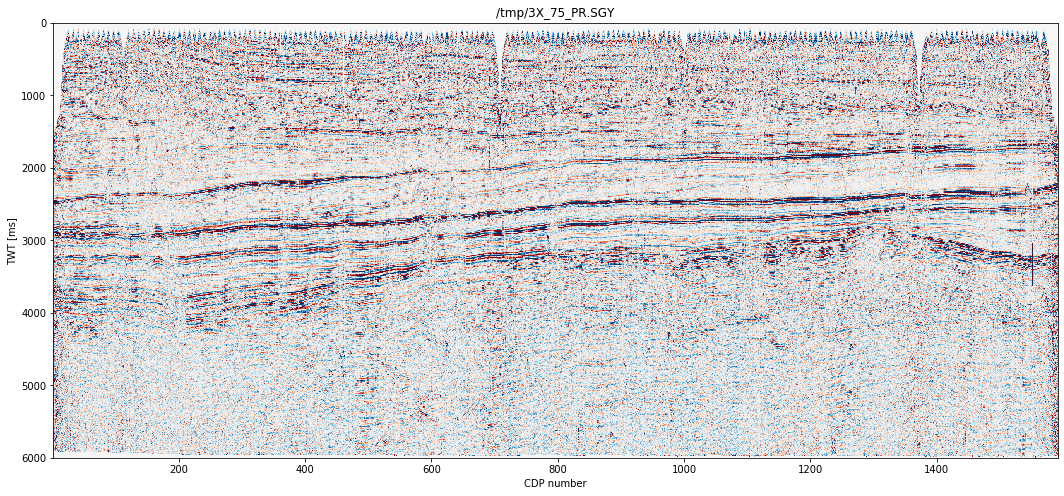

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(1, 1, 1)
extent = [1, n_traces, twt[-1], twt[0]]  # define extent
ax.imshow(data.T, cmap="RdBu", vmin=-vm, vmax=vm, aspect='auto', extent=extent)
ax.set_xlabel('CDP number')
ax.set_ylabel('TWT [ms]')
ax.set_title(f'{raw.files[0]}')
